In [2]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
import seaborn as sns
import warnings
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

/Users/administrator/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
house_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()


house_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


Let's find out what types of data we having

In [4]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

In [10]:
non_numeric_columns = house_df.select_dtypes(['object']).columns
print(non_numeric_columns)
print("The number of non-numerical columns is {}".format(len(non_numeric_columns)))

Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')
The number of non-numerical columns is 43


In [11]:
numeric_columns = house_df.select_dtypes(['int64', 'float64']).columns
print(numeric_columns)
print("The number of numerical columns is {}".format(len(numeric_columns)))

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', 'threessnporch', 'screenporch',
       'poolarea', 'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')
The number of numerical columns is 38


In [7]:
total_missing = house_df.isnull().sum().sort_values(ascending=False)
percent_missing = (house_df.isnull().sum()/house_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total_missing, percent_missing], axis=1, keys=['Total', 'Percent'])
missing_data.head (25)

,Total,Percent
poolqc,1453,0.995205
miscfeature,1406,0.963014
alley,1369,0.937671
fence,1179,0.807534
fireplacequ,690,0.472603
lotfrontage,259,0.177397
garagecond,81,0.055479
garagetype,81,0.055479
garageyrblt,81,0.055479
garagefinish,81,0.055479


So we see that some of the data is missing on purpose. If the field is empty means that either this feauture is false either it wasn't filled by a listing agent. For the purpose of modelling it will be better not to include this data into the experiment with more than 10% of missing values and replace with 0 all the values where n/a We should avoid using variables with missing data points.

In [9]:
np.abs(house_df[numeric_columns].iloc[:,1:].corr().loc[:,"saleprice"]).sort_values(ascending=False)

saleprice        1.000000
overallqual      0.790982
grlivarea        0.708624
garagecars       0.640409
garagearea       0.623431
totalbsmtsf      0.613581
firstflrsf       0.605852
fullbath         0.560664
totrmsabvgrd     0.533723
yearbuilt        0.522897
yearremodadd     0.507101
garageyrblt      0.486362
masvnrarea       0.477493
fireplaces       0.466929
bsmtfinsf1       0.386420
lotfrontage      0.351799
wooddecksf       0.324413
secondflrsf      0.319334
openporchsf      0.315856
halfbath         0.284108
lotarea          0.263843
bsmtfullbath     0.227122
bsmtunfsf        0.214479
bedroomabvgr     0.168213
kitchenabvgr     0.135907
enclosedporch    0.128578
screenporch      0.111447
poolarea         0.092404
mssubclass       0.084284
overallcond      0.077856
mosold           0.046432
threessnporch    0.044584
yrsold           0.028923
lowqualfinsf     0.025606
miscval          0.021190
bsmthalfbath     0.016844
bsmtfinsf2       0.011378
Name: saleprice, dtype: float64

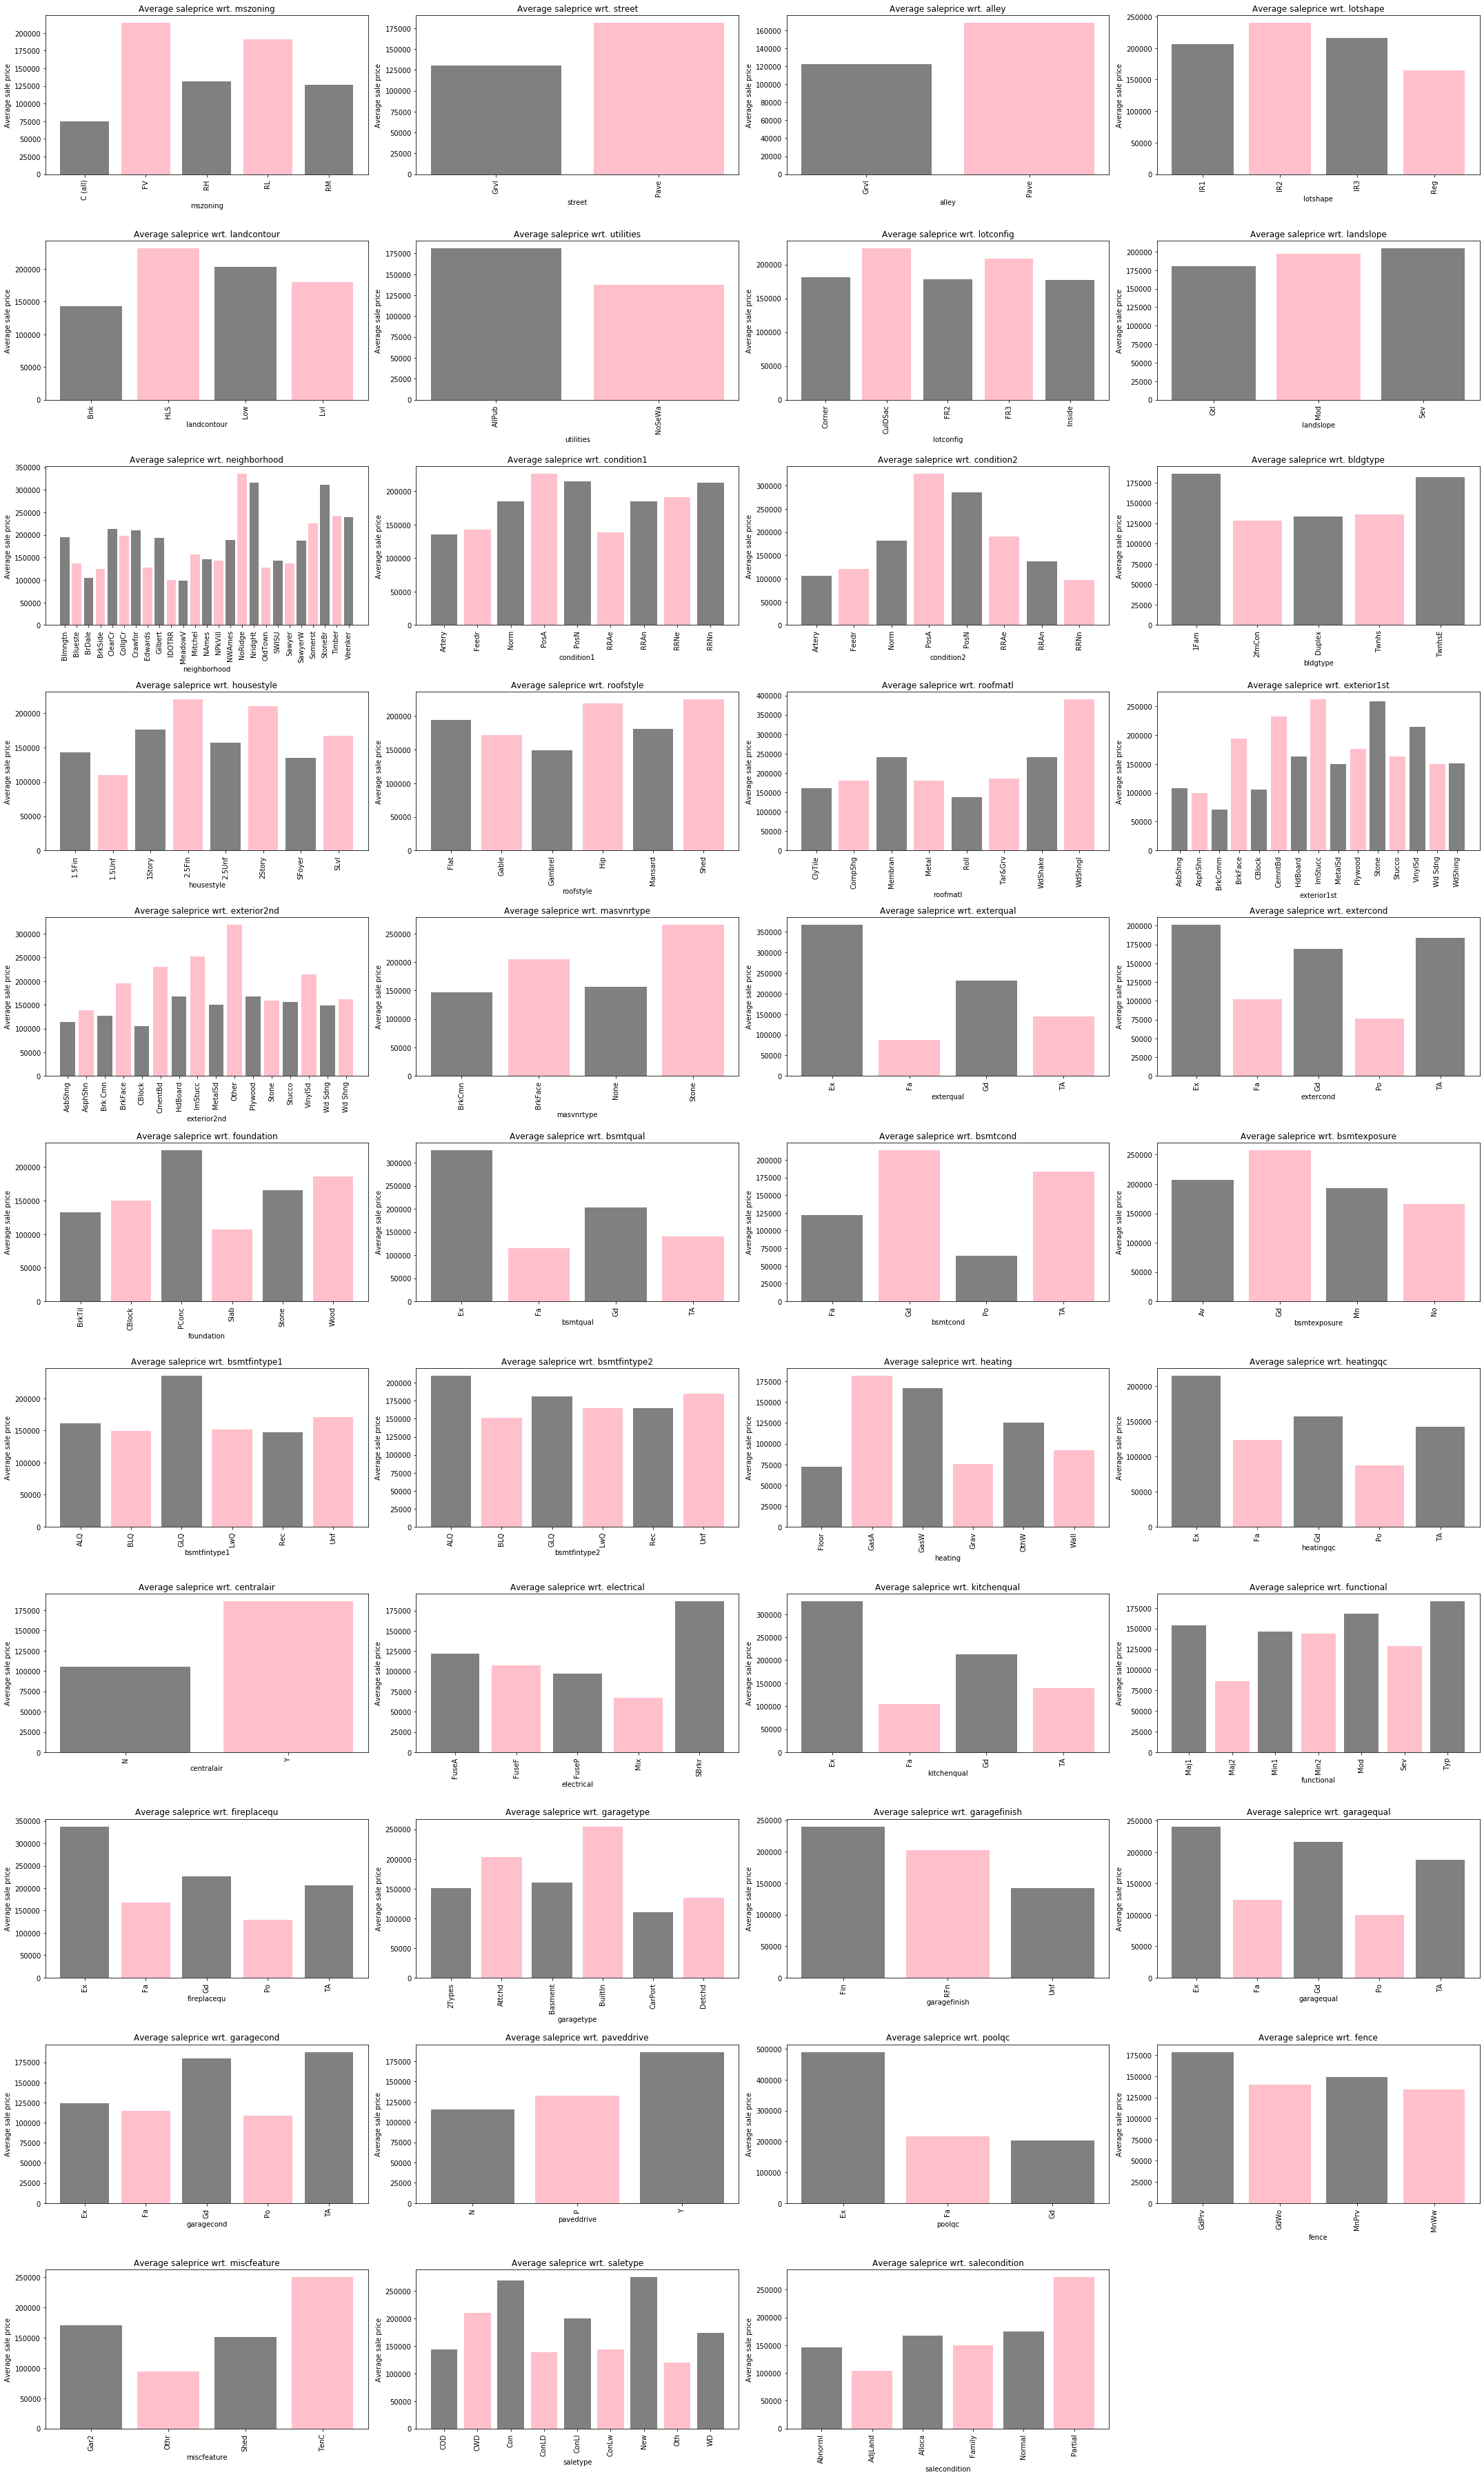

In [10]:
plt.figure(figsize=(30,50))

for index, column in enumerate(non_numeric_columns):
    plt.subplot(11,4,index+1)
    plt.bar(house_df.groupby(column)["saleprice"].mean().index, house_df.groupby(column)["saleprice"].mean(),
           color=("grey","pink"))
    plt.title("Average saleprice wrt. {}".format(column))
    plt.ylabel("Average sale price")
    plt.xlabel(column)
    plt.xticks(rotation='vertical')

plt.tight_layout()
plt.show()

In [12]:
house_df = pd.concat([house_df,pd.get_dummies(house_df.mszoning, prefix="mszoning", drop_first=True)], axis=1)
house_df = pd.concat([house_df,pd.get_dummies(house_df.street, prefix="street", drop_first=True)], axis=1)
dummy_column_names = list(pd.get_dummies(house_df.mszoning, prefix="mszoning", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(house_df.street, prefix="street", drop_first=True).columns)

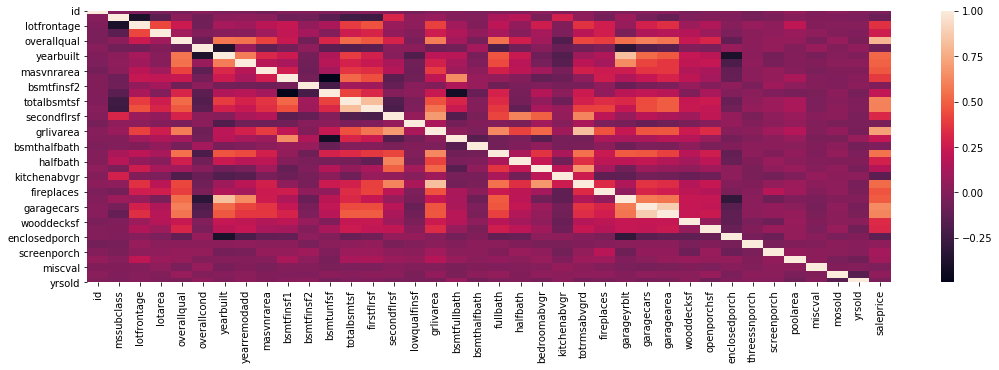

In [12]:
plt.figure(figsize=(18,5))

sns.heatmap(house_df[numeric_columns].corr())
plt.show()

for the model we will choose the variables that correlates the most with out target valriable (that aren't correlate with each other) plus non_numerical values of our choise.

In [14]:
# Y is the target variable
Y = house_df['saleprice']
# X is the feature set which includes
# is_male and is_smoker variables
X = house_df[['overallqual','grlivarea', 'garagecars','totalbsmtsf']+dummy_column_names]

import statsmodels.api as sm

# We need to manually add a constant
# in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     534.7
Date:                Fri, 31 Jan 2020   Prob (F-statistic):               0.00
Time:                        04:02:07   Log-Likelihood:                -17476.
No. Observations:                1460   AIC:                         3.497e+04
Df Residuals:                    1450   BIC:                         3.502e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        -1.15e+05    1.8e+04     -6.389      0.000    -1.5e+05   -7.97e+04
overallqual  2.326e+04   1088.166     21.372      0.000    2.11e+04    2.54e+04
grlivarea      45.9403      2.461     18.666      0.000      41.113      50.768
garagecars   1.729e+04   1741.358      9.927      0.000    1.39e+04    2.07e+04
totalbsmtsf    29.3751      2.864     10.258      0.000      23.758      34.993
mszoning_FV  2.469e+04   1.37e+04      1.803      0.072   -2165.192    5.16e+04
mszoning_RH   1.26e+04   1.58e+04      0.795      0.427   -1.85e+04    4.37e+04
mszoning_RL  2.753e+04   1.27e+04      2.166      0.030    2595.282    5.25e+04
mszoning_RM  7838.2775   1.29e+04      0.609      0.543   -1.74e+04    3.31e+04
street_Pave -1322.4707   1.63e+04     -0.081      0.935   -3.32e+04    3.06e+04
==============================================================================
Omnibus:                      406.416   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            37667.565
Skew:                          -0.052   Prob(JB):                         0.00
Kurtosis:                      27.883   Cond. No.                     5.35e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.35e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

he statistically significant variables are overallqual, grlivarea, garagecars, totalbsmtsf, mszoning_FV and mszoning_RL. All the other variables are statistically insignificant and hence their coefficients are statistically zero. According to the estimation results:

In [15]:
#Now let's exclude statistically insignificant variables from the model and re-estimate it:
Y = house_df['saleprice']
# X is the feature set
X = house_df[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf', 'mszoning_FV', 'mszoning_RL']]

X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     803.3
Date:                Fri, 31 Jan 2020   Prob (F-statistic):               0.00
Time:                        04:02:54   Log-Likelihood:                -17476.
No. Observations:                1460   AIC:                         3.497e+04
Df Residuals:                    1453   BIC:                         3.500e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.087e+05   4792.537    -22.674      0.000   -1.18e+05   -9.93e+04
overallqual  2.332e+04   1078.278     21.628      0.000    2.12e+04    2.54e+04
grlivarea      45.9659      2.452     18.743      0.000      41.155      50.777
garagecars   1.721e+04   1732.720      9.931      0.000    1.38e+04    2.06e+04
totalbsmtsf    29.3276      2.858     10.261      0.000      23.721      34.934
mszoning_FV  1.679e+04   5560.901      3.020      0.003    5885.005    2.77e+04
mszoning_RL  1.968e+04   2833.445      6.946      0.000    1.41e+04    2.52e+04
==============================================================================
Omnibus:                      406.420   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            37605.498
Skew:                          -0.057   Prob(JB):                         0.00
Kurtosis:                      27.863   Cond. No.                     1.11e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.11e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The results resemble the previous model's results. The estimated coefficients are close to the previous model except the dummy variables. The coefficients of the dummies changed relatively larger than the other variables.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

The number of observations in training set is 1168
The number of observations in test set is 292


In [18]:
X_train = sm.add_constant(X_train)

In [19]:
#We fit an OLS model using statsmodels
results = sm.OLS(y_train, X_train).fit()

# We print the summary results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              saleprice   R-squared:                       0.767
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     638.6
Date:                Fri, 31 Jan 2020   Prob (F-statistic):               0.00
Time:                        04:03:58   Log-Likelihood:                -13974.
No. Observations:                1168   AIC:                         2.796e+04
Df Residuals:                    1161   BIC:                         2.800e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.088e+05   5354.166    -20.325      

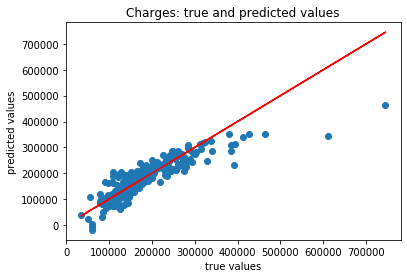

Mean absolute error of the prediction is: 25689.23925664506
Mean squared error of the prediction is: 1556865953.3471115
Root mean squared error of the prediction is: 39457.140714287845
Mean absolute percentage error of the prediction is: 15.632973457655858


In [20]:
X_test = sm.add_constant(X_test)

# We are making predictions here
y_preds = results.predict(X_test)

plt.scatter(y_test, y_preds)
plt.plot(y_test, y_test, color="red")
plt.xlabel("true values")
plt.ylabel("predicted values")
plt.title("Charges: true and predicted values")
plt.show()

print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds) / y_test)) * 100))

In [21]:
# X is the feature set

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, y_train)
# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

The number of observations in training set is 1168
The number of observations in test set is 292
R-squared of the model in the training set is: 0.7674560120822184
-----Test set statistics-----
R-squared of the model in the test set is: 0.7681062592258237
Mean absolute error of the prediction is: 25689.23925664601
Mean squared error of the prediction is: 1556865953.3471808
Root mean squared error of the prediction is: 39457.140714288726
Mean absolute percentage error of the prediction is: 15.632973457656488


R-squared of the model in the training set is: 0.76 R-squared of the model in the test set is: 0.76 that means we have a strong model for tre predictions and do not overfit

In [13]:
from sklearn import neighbors

# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
X = house_df[['overallqual', 'grlivarea', 'garagecars', 'totalbsmtsf', 'mszoning_FV', 'mszoning_RL']]
Y = house_df.saleprice
knn.fit(X, Y)

# Set up our prediction line.
T = np.arange(0, 50, 0.1)[:, np.newaxis]

# Trailing underscores are a common convention for a prediction.
Y_ = knn.predict(T)

plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.legend()
plt.title('K=10, Unweighted')
plt.show()

ValueError: query data dimension must match training data dimension

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from scipy import stats

neighbors = KNeighborsClassifier(n_neighbors=5, weights='distance')

# Our input data frame will be the z-scores this time instead of raw data.
X = pd.DataFrame({
    'grlivarea': stats.zscore(house_df.grlivarea),
    'overallqual': stats.zscore(house_df.overallqual)
})

In [26]:
from sklearn import neighbors

# Build our model.
knn = neighbors.KNeighborsRegressor(n_neighbors=10)
X = pd.DataFrame({
    'grlivarea': stats.zscore(house_df.grlivarea),
    'overallqual': stats.zscore(house_df.overallqual)
})
Y = pd.DataFrame({
    'saleprice': stats.zscore(house_df.saleprice)
})  

ValueError: x and y must be the same size

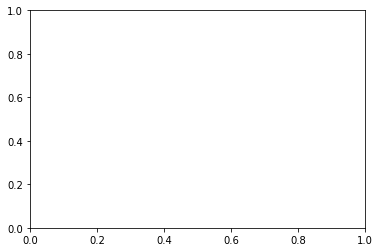

In [31]:
knn.fit(X, Y)

# Set up our prediction line.
T = np.arange(0, 50, 0.1)[:, np.newaxis]

plt.scatter(X, Y, c='k', label='data')
plt.legend()
plt.title('K=10, Unweighted')
plt.show()

In [30]:
# Trailing underscores are a common convention for a prediction.
Y_ = knn.predict(T)

plt.scatter(X, Y, c='k', label='data')
plt.plot(T, Y_, c='g', label='prediction')
plt.legend()
plt.title('K=10, Unweighted')
plt.show()

ValueError: query data dimension must match training data dimension